This Notebook demonstrates how to use the functions in `../utils`.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({'font.family': 'Arial', 'font.size':11})

sys.path.append('../src')
import shtools
import constants
import icgem

home_dir = os.getcwd()
data_dir = os.path.join(home_dir, 'data')

# Download and read spherical harmonic coefficients (ICGEM format)

The function `read_shc` in `../utils/shtools` can be used to read certain attributes from a `.gfc` file downloaded from [ICGEM](https://icgem.gfz-potsdam.de/tom_longtime). 

In [3]:
model = 'GO_CONS_GCF_2_TIM_R6e'
# icgem.download_ggm(model_name=model)

fname = 'downloads/' + model + '.gfc'

shc = icgem.read_icgem(fname)
print(f'\nData type of shc: {type(shc)}')


Data type of shc: <class 'dict'>


`read_shc` returns a dict, which contains:

<pre>
- 'a'       : The reference radius.
- 'nmax'    : The maximum degree of expansion.
- 'GM'      : The Earth's gravitational constant.
- 'Cnm'     : A numpy array containing the cosine coefficients.
- 'Snm'     : A numpy array containing the sine coefficients.
- 'sCnm'    : A numpy array containing the formal cosine errors.
- 'sSnm'    : A numpy array containing the formal sine errors.
- 'tide_sys': The tide system used in the model.
</pre>

We can print out radius, nmax, GM, and tide system and compare with the values in `model` (open the .gfc file in a text editor to see these values). For reference, the values in the `.gfc` file are:

<pre>
- radius                 (a)          : 6378136.46
- max_degree             (nmax)       : 300
- earth_gravity_constant (GM)         : 3.986004415E+14
- tide_system            (tide_sys)   : zero_tide
</pre>


In [4]:
for key in ['a', 'nmax', 'GM', 'tide_sys']:
    print(f'{key:<10}: {shc[key]}')

a         : 6378136.46
nmax      : 300
GM        : 398600441500000.0
tide_sys  : zero_tide


# Degree Variances

Constants from the global geopotential model

In [5]:
# variances1 = shtools.degree_amplitude1(shc, ellipsoid='grs80')
variances  = shtools.degree_amplitude(shc, ellipsoid='grs80')
error_variances = shtools.error_degree_amplitude(shc, ellipsoid='grs80')

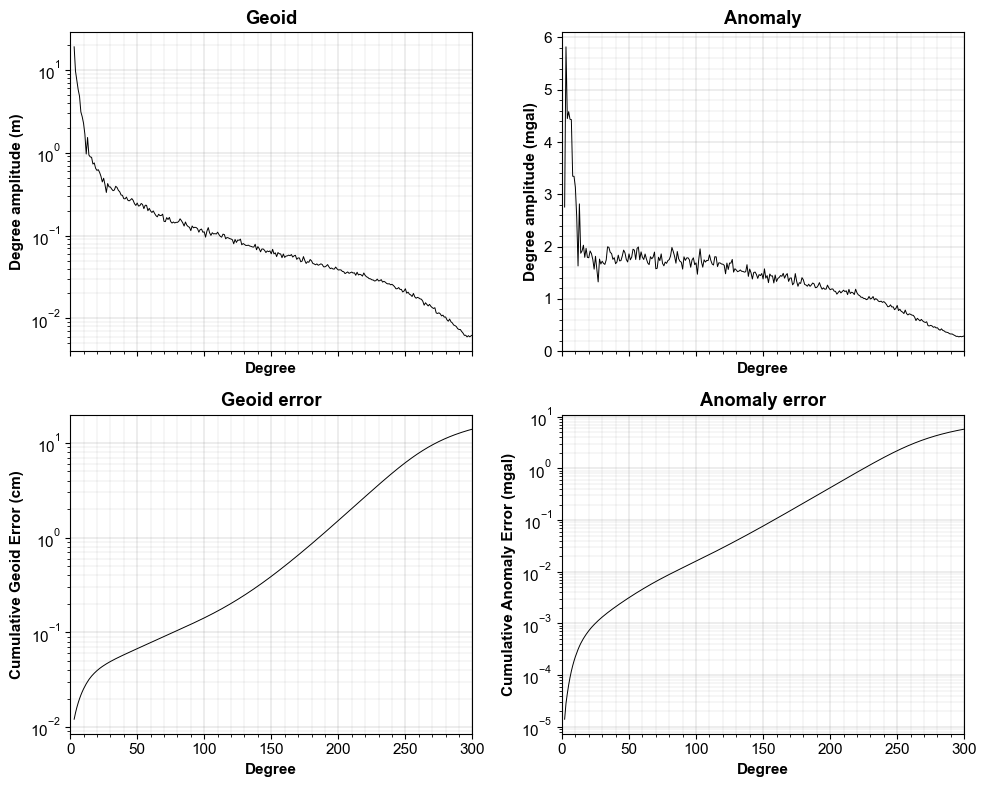

In [6]:
fig, axs = plt.subplots(2,2, figsize=(10,8), sharex=True)

axs = axs.ravel()

axs[0].plot(variances['degree'][3:], variances['geoid'][3:], linewidth=0.7, color='k')
axs[1].plot(variances['degree'][2:], variances['anomaly'][2:], linewidth=0.7, color='k')
axs[2].plot(error_variances['degree'][3:], error_variances['error_geoid'][3:], linewidth=0.7, color='k')
axs[3].plot(error_variances['degree'][2:], error_variances['error_anomaly'][2:], linewidth=0.7, color='k')

titles = ['Geoid', 'Anomaly', 'Geoid error', 'Anomaly error']
ylabels = ['Degree amplitude (m)', 'Degree amplitude (mgal)', 'Cumulative Geoid Error (cm)', 'Cumulative Anomaly Error (mgal)']

xlims  = [0, shc['nmax']]
ylims  = [[0, 20], [0, 6]]

for i, (ax, title) in enumerate(zip(axs, titles)):
    ax.set_title(title, fontweight='bold')
    ax.set_xlabel('Degree', fontweight='bold')
    ax.set_ylabel(ylabels[i], fontweight='bold')
    ax.set_xlim(xlims)
    
    if i != 1:
        ax.set_yscale('log')
    
    ax.grid(which='both', linewidth=0.5, color='gray')
    ax.minorticks_on()
    ax.grid(which='minor', linewidth=0.1, color='gray')
    ax.grid(linewidth=0.2)


fig.tight_layout()
plt.show()

# Gravity Anomalies

In [12]:
import coordinates as co
from legendre import ALF
import pandas as pd
from ggm_tools import gravity_anomaly

In [20]:
grav_data = pd.read_csv('MeanTideGravity.csv')
grav_data.head()

,lon,lat,height,gravity
0,-0.166667,5.600000,66.45,978100.60
1,-0.183333,5.600000,96.32,978091.07
2,-0.333333,5.800000,50.29,978086.51
3,-0.083333,5.883333,73.15,978092.46
4,-0.033333,6.066667,83.82,978086.30


In [10]:
shc = shtools.replace_zonal_harmonics(shc, ellipsoid='grs80')

In [24]:
Dg = gravity_anomaly(shc=shc, grav_data=grav_data, ellipsoid='grs80', nmax=300)

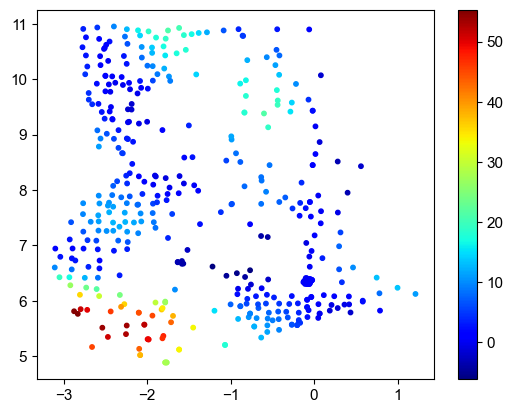

In [25]:
plt.scatter(grav_data['lon'], grav_data['lat'], c=Dg, cmap='jet', s=10)
plt.colorbar()
plt.show()

In [28]:
elev_column = [col for col in grav_data.columns if pd.Series(col).str.contains(r'elev|height', case=False).any()][0]
elev_column

'Height'

In [14]:
def ALFsGravityAnomaly(phi=None, lambd=None, vartheta=None, nmax=60, ellipsoid='wgs84'):
    '''
    Compute associated Legendre functions

    Parameters
    ----------
    phi       : geodetic latitude (degrees)
    lambd     : geodetic longitude (degrees)
    vartheta  : colatitude (radians)
    nmax      : maximum degree of expansion
    ellipsoid : reference ellipsoid ('wgs84' or 'grs80')
    
    Returns
    -------
    Pnm       : Fully normalized Associated Legendre functions
    
    References
    ----------
    (1) Holmes and Featherstone (2002): A unified approach to the Clenshaw 
    summation and the recursive computation of very high degree and order 
    normalised associated Legendre functions (Eqs. 11 and 12)
    '''
    if phi is None and vartheta is None:
        raise ValueError('Either phi or vartheta must be provided')
    
    if lambd is None and vartheta is None:
        raise ValueError('Please provide lambd')
    
    if vartheta is not None: 
        phi_bar = vartheta
    elif phi is not None:
        _, phi_bar, _ = co.geodetic2spherical(phi, lambd, ellipsoid, height=0)
    
    t = np.cos(phi_bar)
    u = np.sin(phi_bar)

    if vartheta is not None:
        Pnm = np.zeros((len(vartheta), nmax + 1, nmax + 1))
    elif phi is not None:
        Pnm = np.zeros((len(phi), nmax + 1, nmax + 1))
        
    Pnm[:, 0, 0] = 1.0

    if nmax >= 1:
        Pnm[:, 1, 0] = np.sqrt(3.0) * t
        Pnm[:, 1, 1] = np.sqrt(3.0) * u

    for n in range(2, nmax + 1):
        for m in range(0, n):
            a_nm = np.sqrt((2. * n - 1.) * (2. * n + 1.0) / ((n - m) * (n + m)))
            b_nm = 0.
            if n - m - 1 >= 0:
                b_nm = np.sqrt((2. * n + 1.) * (n + m - 1.) * (n - m - 1.) / ((n - m) * (n + m) * (2. * n - 3.)))
            Pnm[:, n, m] = a_nm * t * Pnm[:, n - 1, m] - b_nm * Pnm[:, n - 2, m]
        # Sectoral harmonics (n = m)
        Pnm[:, n, n] = u * np.sqrt((2. * n + 1.) / (2. * n)) * Pnm[:, n - 1, n - 1]

    return Pnm

def gravity_anomaly(shc, grav_data=None, ellipsoid='wgs84', nmax=300):
    '''
    Calculate gravity anomalies from global model
    
    Parameters
    ----------
    shc       : Spherical Harmonic Coefficients (output of icgem.read_icgem())
    grav_data : Gravity data with columns lon, lat, and elevation: lat and lon units: degrees
    ellipsoid : Reference ellipsoid
    nmax      : Maximum spherical harmonic degree of expansion
    
    Returns
    -------
    Dg        : Gravity anomaly (mGal)
    '''
    if grav_data is None:
        raise ValueError('Provide data with columns lon, lat, and elevation in order')
    else:
        if isinstance(grav_data, np.ndarray):
            lon = grav_data[:,0]
            lat = grav_data[:,1]
            h   = grav_data[:,2]
        elif isinstance(grav_data, pd.DataFrame):
            lon_column = [col for col in grav_data.columns if pd.Series(col).str.contains('lon', case=False).any()][0]
            lat_column = [col for col in grav_data.columns if pd.Series(col).str.contains('lat', case=False).any()][0]
            lon = grav_data[lon_column].values
            lat = grav_data[lat_column].values
            try:
                elev_column = [col for col in grav_data.columns if pd.Series(col).str.contains('elev', case=False).any()][0]
                h = grav_data[elev_column].values
            except IndexError:
                print('Looks like there is no elevation column. Setting elevation to 0')
                h = np.zeros(len(lat))
                
    r, vartheta, _ = co.geodetic2spherical(phi=lat, lambd=lon, height=h, ellipsoid=ellipsoid)
    
    lon = np.radians(lon)
    lat = np.radians(lat)
    
    Pnm = ALFsGravityAnomaly(vartheta=vartheta, nmax=nmax, ellipsoid=ellipsoid)
    
    # Gravity anomalies
    Dg = np.zeros(len(grav_data))
        
    for n in range(1, nmax+1):
        sum_term = np.zeros(len(grav_data))
        for m in range(n+1):
            sum_term += (shc['Cnm'][n, m] * np.cos(m*lon)) + (shc['Snm'][n, m] * np.sin(m*lon)) * Pnm[:, n, m]
        Dg += (n-1) * (shc['a'] / r) ** n * sum_term
    
    Dg = shc['GM'] / r ** 2 * Dg * 10**5 # mGal
    
    return Dg

In [15]:
phi = np.array([12, 12, 12])
lambd = np.array([-4, -4, -4])

Pnm = ALF_multi(phi=phi, lambd=lambd, nmax=5, ellipsoid='grs80')

In [18]:
print(Pnm[0])

[[ 1.          0.          0.          0.          0.          0.        ]
 [ 0.36011361  1.69420134  0.          0.          0.          0.        ]
 [-0.97304531  0.78764212  1.85278242  0.          0.          0.        ]
 [-0.76567752 -1.24225162  1.01918343  1.95750198  0.          0.        ]
 [ 0.66321853 -1.30104221 -1.11903241  1.22096264  2.03087347  0.        ]
 [ 1.04226145  0.68171819 -1.4709461  -0.99162501  1.4004194   2.08345249]]


In [19]:
print(Pnm[1])

[[ 1.          0.          0.          0.          0.          0.        ]
 [ 0.36011361  1.69420134  0.          0.          0.          0.        ]
 [-0.97304531  0.78764212  1.85278242  0.          0.          0.        ]
 [-0.76567752 -1.24225162  1.01918343  1.95750198  0.          0.        ]
 [ 0.66321853 -1.30104221 -1.11903241  1.22096264  2.03087347  0.        ]
 [ 1.04226145  0.68171819 -1.4709461  -0.99162501  1.4004194   2.08345249]]


In [21]:
print(Pnm[2])

[[ 1.          0.          0.          0.          0.          0.        ]
 [ 0.36011361  1.69420134  0.          0.          0.          0.        ]
 [-0.97304531  0.78764212  1.85278242  0.          0.          0.        ]
 [-0.76567752 -1.24225162  1.01918343  1.95750198  0.          0.        ]
 [ 0.66321853 -1.30104221 -1.11903241  1.22096264  2.03087347  0.        ]
 [ 1.04226145  0.68171819 -1.4709461  -0.99162501  1.4004194   2.08345249]]


In [14]:
lon = np.linspace(-180, 180, 360)
lat = np.linspace(-90, 90, 180)
h   = 0
[lon, lat] = np.meshgrid(lon, lat)

r, vartheta, _ = co.geodetic2spherical(phi=lat, lambd=lon, height=h, ellipsoid='grs80')

In [9]:
Pnm = ALF(phi=12, lambd=-4, nmax=5, ellipsoid='grs80')

In [10]:
Pnm1 = ALF(vartheta=1.361356816555577, nmax=5, ellipsoid='grs80') 

In [26]:
Pnm.shape

(61, 61)

# Reference Geoid

In [6]:
from ggm_geoid import reference_geoid

In [9]:
import coordinates as co

In [12]:
co.geodetic2geocentric(80)

79.93397880982552

In [18]:
import gravity

In [21]:
gravity.normal_gravity(0)

9.7803253359

In [24]:
import constants

In [26]:
constants.wgs84()

{'semi_major': 6378137,
 'semi_minor': 6356752.3142,
 'GM': 398600441800000.0,
 'w': 7.292115e-05,
 'E': 521854.00842339,
 'c': 6399593.6258,
 'e': 0.081819190842622,
 'e2': 0.00669437999014,
 'ep': 0.082094437949696,
 'ep2': 0.00673949674228,
 'f': 0.0033528106647474805,
 'U0': 62636851.7146,
 'm': 0.00344978650684,
 'gamma_a': 9.7803253359,
 'gamma_b': 9.8321849378,
 'mean_gamma': 9.7976432222,
 'C20': -0.000484166774985,
 'C40': 7.90303733511e-07,
 'C60': -1.68724961151e-09,
 'C80': 3.46052468394e-12,
 'C100': -2.65002225747e-15}

In [25]:
constants.grs80()

{'semi_major': 6378137,
 'semi_minor': 6356752.3141,
 'GM': 398600500000000.0,
 'J2': 0.00108263,
 'w': 7.292115e-05,
 'E': 521854.0097,
 'c': 6399593.6259,
 'e2': 0.0066943800229,
 'ep2': 0.00673949677548,
 'f': 0.003352810681,
 '1/f': 298.257222101,
 'U0': 62636860.85,
 'J4': -2.37091222e-06,
 'J6': 6.08347e-09,
 'J8': -1.427e-11,
 'm': 0.00344978600308,
 'gamma_a': 9.7803267715,
 'gamma_b': 9.8321863685,
 'C20': -0.000484166854903603,
 'C40': 7.90304072916597e-07,
 'C60': -1.68725117581045e-09,
 'C80': 3.46053239866698e-12,
 'C100': -2.65006218130312e-15}

In [27]:
X = 2
Y = 10
Z = 7

psi = np.arctan( Z / (X**2 + Y**2) )
vartheta = np.pi/2 - psi
print(f'Colatitude is: {vartheta}')

psi = np.arctan( (X**2 + Y**2) / Z )
print(f'Colatitude is: {psi}')

Colatitude is: 1.5035900010125318
Colatitude is: 1.5035900010125318


In [3]:
import numpy as np
a = np.array([
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]
])

b = np.array([1, 2, 3])
test_dict = {'a': a, 'b': b}

print(test_dict['a'])

test_dict['a'][0,0] = 100

test_dict['a']

[[1 2 3]
 [4 5 6]
 [7 8 9]]


array([[100,   2,   3],
       [  4,   5,   6],
       [  7,   8,   9]])

In [ ]:
# Interpolate the free_air_anomaly and bouguer_anomaly onto the grid
grid_free_air_anomaly = scipy.interpolate.griddata(points, values_free_air, (grid_Lon, grid_Lat), method='cubic')
grid_bouguer_anomaly = scipy.interpolate.griddata(points, values_bouguer, (grid_Lon, grid_Lat), method='cubic')